# Training checkpoints

## 1. Setup

In [1]:
import tensorflow as tf

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


In [2]:
class Net(tf.keras.Model):
  """A simple linear model."""

  def __init__(self):
    super(Net, self).__init__()
    self.l1 = tf.keras.layers.Dense(5)

  def call(self, x):
    return self.l1(x)

In [3]:
net = Net()

## 2. Saving from tf.keras training APIs

In [4]:
# See the tf.keras guide on saving and restoring.

# tf.keras.Model.save_weights saves a TensorFlow checkpoint.

net.save_weights('easy_checkpoint')

## 3. Writing checkpoints

### i. Manual checkpointing

### Setup

In [5]:
# To help demonstrate all the features of tf.train.Checkpoint, define a toy dataset and optimization step:

def toy_dataset():
  inputs = tf.range(10.)[:, None]
  labels = inputs * 5. + tf.range(5.)[None, :]
  return tf.data.Dataset.from_tensor_slices(
    dict(x=inputs, y=labels)).repeat().batch(2)

In [6]:
def train_step(net, example, optimizer):
  """Trains `net` on `example` using `optimizer`."""
  with tf.GradientTape() as tape:
    output = net(example['x'])
    loss = tf.reduce_mean(tf.abs(output - example['y']))
  variables = net.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss

### Create the checkpoint objects

In [7]:
opt = tf.keras.optimizers.Adam(0.1)
dataset = toy_dataset()
iterator = iter(dataset)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

### Train and checkpoint the model

In [8]:
def train_and_checkpoint(net, manager):
  ckpt.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  for _ in range(50):
    example = next(iterator)
    loss = train_step(net, example, opt)
    ckpt.step.assign_add(1)
    if int(ckpt.step) % 10 == 0:
      save_path = manager.save()
      print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
      print("loss {:1.2f}".format(loss.numpy()))

In [9]:
train_and_checkpoint(net, manager)

Initializing from scratch.
Saved checkpoint for step 10: ./tf_ckpts\ckpt-1
loss 30.21
Saved checkpoint for step 20: ./tf_ckpts\ckpt-2
loss 23.63
Saved checkpoint for step 30: ./tf_ckpts\ckpt-3
loss 17.07
Saved checkpoint for step 40: ./tf_ckpts\ckpt-4
loss 10.59
Saved checkpoint for step 50: ./tf_ckpts\ckpt-5
loss 4.42


### Restore and continue training

In [10]:
# After the first training cycle you can pass a new model and manager, but pick up training exactly where you left off:

opt = tf.keras.optimizers.Adam(0.1)
net = Net()
dataset = toy_dataset()
iterator = iter(dataset)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

train_and_checkpoint(net, manager)

Restored from ./tf_ckpts\ckpt-5
Saved checkpoint for step 60: ./tf_ckpts\ckpt-6
loss 1.41
Saved checkpoint for step 70: ./tf_ckpts\ckpt-7
loss 0.78
Saved checkpoint for step 80: ./tf_ckpts\ckpt-8
loss 0.52
Saved checkpoint for step 90: ./tf_ckpts\ckpt-9
loss 0.28
Saved checkpoint for step 100: ./tf_ckpts\ckpt-10
loss 0.22


In [12]:
# The tf.train.CheckpointManager object deletes old checkpoints. 
# Above it's configured to keep only the three most recent checkpoints.

print(manager.checkpoints)  # List the three remaining checkpoints

['./tf_ckpts\\ckpt-8', './tf_ckpts\\ckpt-9', './tf_ckpts\\ckpt-10']


In [15]:
%ls .\tf_ckpts

 驱动器 D 中的卷是 Data
 卷的序列号是 12E0-D62D

 D:\miniconda\workspace\TensorFlow2Gride\tf_ckpts 的目录

2021/04/05  19:50    <DIR>          .
2021/04/05  19:50    <DIR>          ..
2021/04/05  19:50               346 checkpoint
2021/04/05  19:50             1,846 ckpt-10.data-00000-of-00001
2021/04/05  19:50               936 ckpt-10.index
2021/04/05  19:50             1,846 ckpt-8.data-00000-of-00001
2021/04/05  19:50               936 ckpt-8.index
2021/04/05  19:50             1,846 ckpt-9.data-00000-of-00001
2021/04/05  19:50               936 ckpt-9.index
               7 个文件          8,692 字节
               2 个目录 318,228,983,808 可用字节


## 4. Loading mechanics

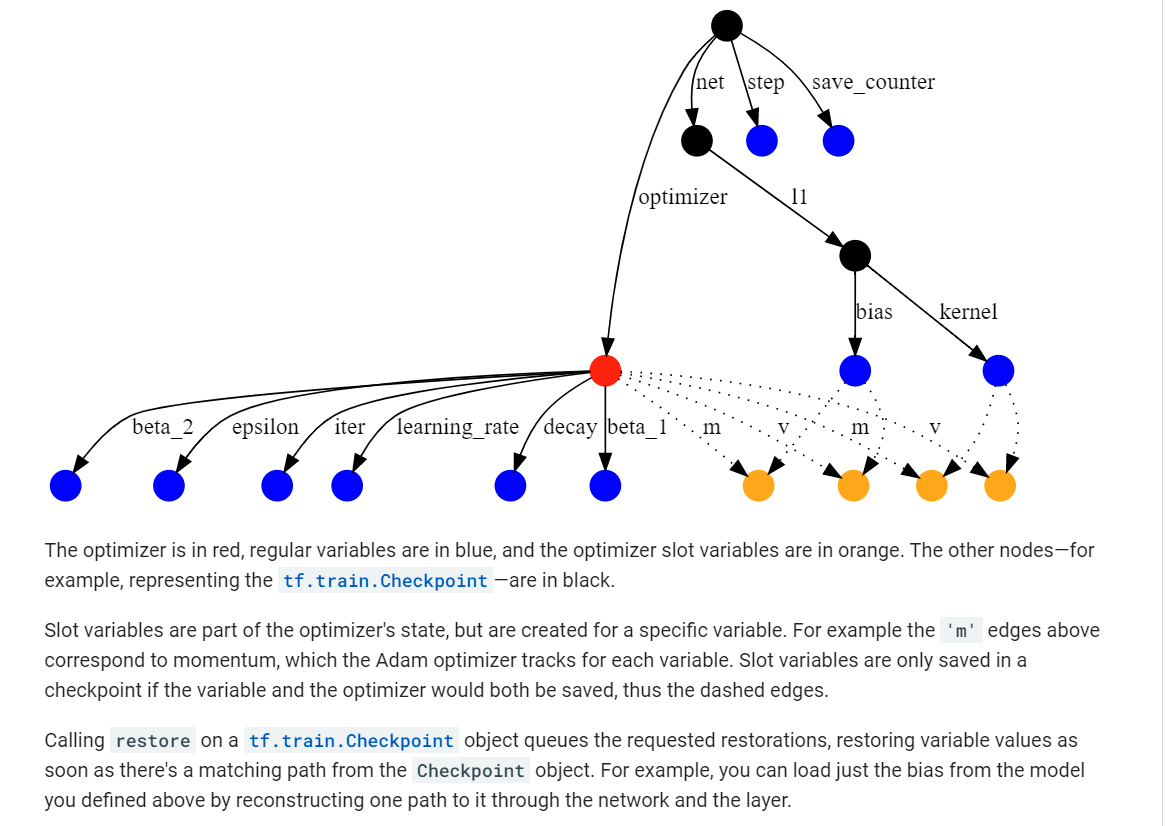

In [17]:
from IPython.display import Image, display
display(Image(filename="./image/loadMechanism.png", embed=True))

In [18]:
to_restore = tf.Variable(tf.zeros([5]))
print(to_restore.numpy())  # All zeros
fake_layer = tf.train.Checkpoint(bias=to_restore)
fake_net = tf.train.Checkpoint(l1=fake_layer)
new_root = tf.train.Checkpoint(net=fake_net)
status = new_root.restore(tf.train.latest_checkpoint('./tf_ckpts/'))
print(to_restore.numpy())  # This gets the restored value.

[0. 0. 0. 0. 0.]
[2.4194186 3.4089255 2.896877  3.804457  4.870106 ]


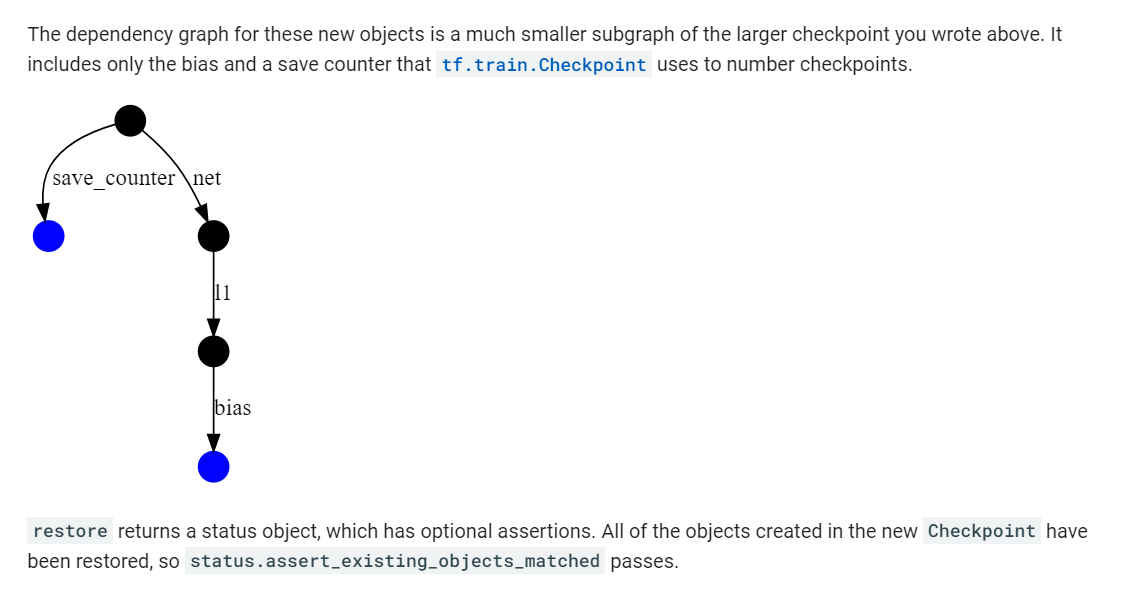

In [19]:
from IPython.display import Image, display
display(Image(filename="./image/loadMechanism2.png", embed=True))

In [20]:
status.assert_existing_objects_matched()

### i. Delayed restorations

In [22]:
# To support this idiom, tf.train.Checkpoint queues restores which don't yet have a matching variable.

delayed_restore = tf.Variable(tf.zeros([1, 5]))
print(delayed_restore.numpy())  # Not restored; still zeros
fake_layer.kernel = delayed_restore
print(delayed_restore.numpy())  # Restored

[[0. 0. 0. 0. 0.]]
[[4.590311  4.686111  4.8597617 4.8383594 4.833709 ]]


### ii. Manually inspecting checkpoints

In [23]:
reader = tf.train.load_checkpoint('./tf_ckpts/')
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'iterator/.ATTRIBUTES/ITERATOR_STATE',
 'net/l1/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'net/l1/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'net/l1/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'net/l1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'net/l1/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'net/l1/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'optimizer/beta_1/.ATTRIBUTES/VARIABLE_VALUE',
 'optimizer/beta_2/.ATTRIBUTES/VARIABLE_VALUE',
 'optimizer/decay/.ATTRIBUTES/VARIABLE_VALUE',
 'optimizer/iter/.ATTRIBUTES/VARIABLE_VALUE',
 'optimizer/learning_rate/.ATTRIBUTES/VARIABLE_VALUE',
 'save_counter/.ATTRIBUTES/VARIABLE_VALUE',
 'step/.ATTRIBUTES/VARIABLE_VALUE']

In [24]:
# So if you're interested in the value of net.l1.kernel you can get the value with the following code:

key = 'net/l1/kernel/.ATTRIBUTES/VARIABLE_VALUE'

print("Shape:", shape_from_key[key])
print("Dtype:", dtype_from_key[key].name)

Shape: [1, 5]
Dtype: float32


In [25]:
# It also provides a get_tensor method allowing you to inspect the value of a variable:

reader.get_tensor(key)

array([[4.590311 , 4.686111 , 4.8597617, 4.8383594, 4.833709 ]],
      dtype=float32)

### iii. List and dictionary tracking

In [26]:
# As with direct attribute assignments like self.l1 = tf.keras.layers.Dense(5), 
# assigning lists and dictionaries to attributes will track their contents.

save = tf.train.Checkpoint()
save.listed = [tf.Variable(1.)]
save.listed.append(tf.Variable(2.))
save.mapped = {'one': save.listed[0]}
save.mapped['two'] = save.listed[1]
save_path = save.save('./tf_list_example')

restore = tf.train.Checkpoint()
v2 = tf.Variable(0.)
assert 0. == v2.numpy()  # Not restored yet
restore.mapped = {'two': v2}
restore.restore(save_path)
assert 2. == v2.numpy()

In [27]:
restore.listed = []
print(restore.listed)  # ListWrapper([])
v1 = tf.Variable(0.)
restore.listed.append(v1)  # Restores v1, from restore() in the previous cell
assert 1. == v1.numpy()

ListWrapper([])


# 5. Summary

# reference

### https://tensorflow.google.cn/guide/checkpoint